#### NOVA IMS / BSc in Data Science / Deep Learning 2024/2025
## <b>Group Project: Image Classification  </b>

#### Group:
- `Laura Matias (20221836)`
- `Marta Almendra (20221878)`
- `Marta Aliende (20241453)`
- `Matilde Casimiro (20221940)` 
- `Teresa Simão (20221873)` 

#### Table of Contents <a class="anchor" id='toc'></a> 
- [1. Metadata Preprocessing](#p1) 
    - [1.1. Missing Values](#p11)
    - [1.2. Data Transformations](#p12)
    - [1.3. Visualizations](#p13)
    - [1.4. Train-Test Split](#p14)
- [2. Image Preprocessing](#p2)
    - [2.1. Image Resizing and Normalizing](#p21)
    - [2.2. Duplicated Images](#p21)
    - [2.2. Color Transformation and Normalization](#p22)
    - [2.3. Data Augmentation](#p23)
- [3. Stage 1: Binary Classification](#p3) 
    - [3.1. Base Models](#p31)
    - [3.2. Callbacks](#p32)
    - [3.3. Hypertuning the models](#p33)
    - [3.4. Model Evaluation](#p34)
    - [3.5. Final Model](#p35)
- [4. Stage 2: Multiclass Classification](#p4) 
    - [4.1. Class Weight](#p41)
    - [4.2. Hypertuning the models](#p42)
    - [4.3. Model Evaluation](#p43)
    - [4.4. Final Model](#p44)    

---

#### Definition of the Problem and Objectives

Breast cancer is a significant health challenge globally, and timely diagnosis is crucial for effective treatment and management. In this project, we aim to apply deep learning techniques to aid the process of breast cancer diagnosis through image classification, using high-resolution microscopic images from the BreaKHis dataset. The task is divided in two stages, first we create a binary classifier to distinguish between benign and malignant tumors, and then extend the model for multi-class classification to identify specific tumor types. 

#### Import the libraries

In [ ]:
# General libraries 
import numpy as np
import pandas as pd
import random
import os
import shutil

# Preprocessing 
import cv2  
from PIL import Image  
from sklearn.model_selection import train_test_split  
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# Modeling 
import tensorflow as tf 
import keras_tuner as kt
from keras.models import Sequential 
from tensorflow.keras.applications import (ResNet50, VGG16)
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout 
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight


#!pip install keras-tuner

# Visualizations 
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Utils
from utils import *
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

## 1. Metadata Preprocessing <a class="anchor" id="p1"></a>
  
[Back to TOC](#toc)

In [2]:
metadata = pd.read_csv("BreaKHis_v1/histology_slides/breast/image_data.csv")
metadata 

,path_to_image,Benign or Malignant,Cancer Type,Magnification
0,BreaKHis_v1/histology_slides/breast/benign/SOB...,Benign,Adenosis,100X
1,BreaKHis_v1/histology_slides/breast/benign/SOB...,Benign,Adenosis,100X
2,BreaKHis_v1/histology_slides/breast/benign/SOB...,Benign,Adenosis,100X
3,BreaKHis_v1/histology_slides/breast/benign/SOB...,Benign,Adenosis,100X
4,BreaKHis_v1/histology_slides/breast/benign/SOB...,Benign,Adenosis,100X
...,...,...,...,...
7904,BreaKHis_v1/histology_slides/breast/malignant/...,Malignant,Lobular Carcinoma,200X
7905,BreaKHis_v1/histology_slides/breast/malignant/...,Malignant,Lobular Carcinoma,200X
7906,BreaKHis_v1/histology_slides/breast/malignant/...,Malignant,Lobular Carcinoma,200X
7907,BreaKHis_v1/histology_slides/breast/malignant/...,Malignant,Lobular Carcinoma,200X


In [3]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7909 entries, 0 to 7908
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   path_to_image        7909 non-null   object
 1   Benign or Malignant  7906 non-null   object
 2   Cancer Type          7905 non-null   object
 3   Magnification        7905 non-null   object
dtypes: object(4)
memory usage: 247.3+ KB


#### 1.1. Missing Values <a class="anchor" id="p11"></a>

In [4]:
metadata[metadata.isnull().any(axis=1)]

,path_to_image,Benign or Malignant,Cancer Type,Magnification
2871,BreaKHis_v1/histology_slides/breast/malignant/...,NaN,NaN,NaN
3093,BreaKHis_v1/histology_slides/breast/malignant/...,Malignant,NaN,NaN
3228,BreaKHis_v1/histology_slides/breast/malignant/...,NaN,NaN,NaN
4536,BreaKHis_v1/histology_slides/breast/malignant/...,NaN,NaN,NaN


In [5]:
print(metadata.loc[2871, 'path_to_image'])
print(metadata.loc[3093, 'path_to_image'])
print(metadata.loc[3228, 'path_to_image'])
print(metadata.loc[4536, 'path_to_image'])

BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/100X/SOB_M_MC-14-18842-100-014.png
BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/200X/SOB_M_MC-14-13413-200-010.png
BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/400X/SOB_M_MC-14-10147-400-013.png
BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/40X/SOB_M_DC-14-14926-40-012.png


In [6]:
metadata.loc[2871, 'Benign or Malignant'] = 'Malignant'
metadata.loc[2871, 'Cancer Type'] = 'Mucinous Carcinoma'
metadata.loc[2871, 'Magnification'] = '100X'
metadata.loc[3093, 'Cancer Type'] = 'Mucinous Carcinoma'
metadata.loc[3093, 'Magnification'] = '200X'
metadata.loc[3228, 'Benign or Malignant'] = 'Malignant'
metadata.loc[3228, 'Cancer Type'] = 'Mucinous Carcinoma'
metadata.loc[3228, 'Magnification'] = '400X'
metadata.loc[4536, 'Benign or Malignant'] = 'Malignant'
metadata.loc[4536, 'Cancer Type'] = 'Ductal Carcinoma'
metadata.loc[4536, 'Magnification'] = '40X'

#### 1.2. Data Transformations <a class="anchor" id="p12"></a>

##### 1.2.1. Binary Class Column 
Add a column to the dataset with the binary labels (o for benign and 1 for malignant)

In [7]:
metadata['binary_class'] = metadata['Benign or Malignant'].map({'Benign': 0, 'Malignant': 1})

##### 1.2.2. Multiclass Class Column
Add a column to the dataset with the classes (0-7) corresponding to the 8 cancer types.

In [8]:
cancer_type_mappings = {'Adenosis': 0,
                        'Tubular Adenoma': 1,
                        'Phyllodes Tumor': 2,
                        'Ductal Carcinoma': 3,
                        'Lobular Carcinoma': 4,
                        'Mucinous Carcinoma': 5,
                        'Papillary Carcinoma': 6,
                        'Fibroadenoma': 7 }

metadata['multi_class'] = metadata['Cancer Type'].map(cancer_type_mappings)

#### 1.3. Visualizations <a class="anchor" id="p13"></a>

##### 1.3.1. Distribution of Benign vs Malignant

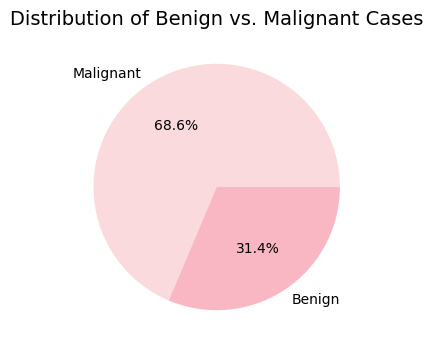

In [9]:
counts = metadata['Benign or Malignant'].value_counts()
plt.figure(figsize=(4,4))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', colors= ["#FADADD", "#F8B7C3"])
plt.title("Distribution of Benign vs. Malignant Cases", fontsize=14)
plt.show()

The dataset is imbalanced.

##### 1.3.2. Distribution of tumor types

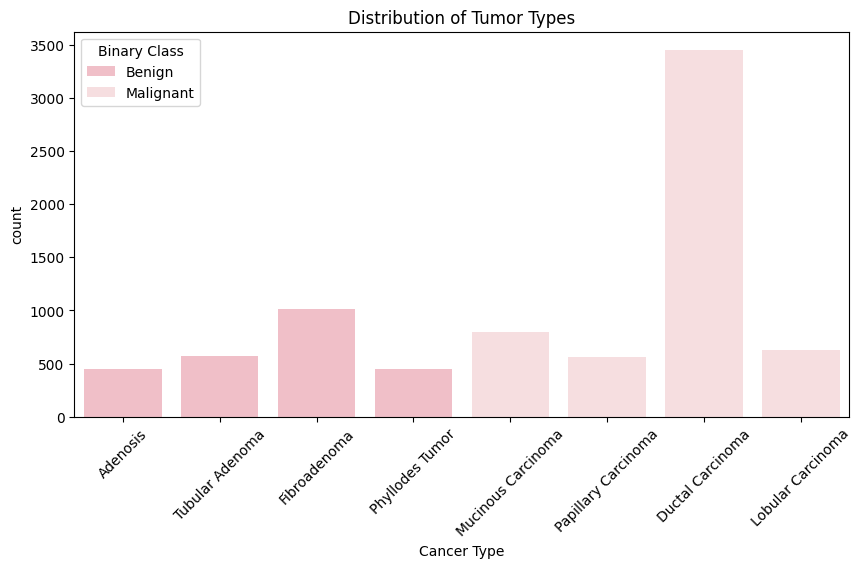

In [10]:
plt.figure(figsize=(10, 5))
sns.countplot(data=metadata, x='Cancer Type', hue='Benign or Malignant', palette= ["#F8B7C3", "#FADADD"])
plt.title("Distribution of Tumor Types")
plt.legend(title="Binary Class", labels=["Benign", "Malignant"])
plt.xticks(rotation=45)
plt.show()

##### 1.3.3. Distributions of magnifications

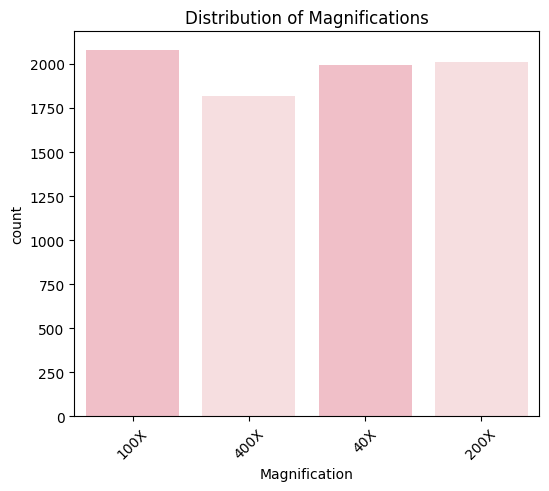

In [11]:
plt.figure(figsize=(6, 5))
sns.countplot(data=metadata, x='Magnification', palette= ["#F8B7C3", "#FADADD"])
plt.title("Distribution of Magnifications")
plt.xticks(rotation=45)
plt.show()

#### 1.4. Train-Test Split <a class="anchor" id="p14"></a>

In [12]:
train, test = train_test_split(metadata, stratify=metadata['binary_class'], test_size=0.2, random_state=42)

In [13]:
print("Training set distribution:")
print(train['binary_class'].value_counts())

print("\nTest set  distribution:")
print(test['binary_class'].value_counts())

Training set distribution:
binary_class
1    4343
0    1984
Name: count, dtype: int64

Test set  distribution:
binary_class
1    1086
0     496
Name: count, dtype: int64


## 2. Image Preprocessing <a class="anchor" id="p2"></a>
  
[Back to TOC](#toc)

#### 2.1. Image Resizing and Normalizing <a class="anchor" id="p21"></a>

As we load the images, we perform resizing of all images to a consistent size (in this case we selected 50x50) and normalizing.

In [14]:
X_train, y_train, w_train = load_images_and_labels(train)
X_test, y_test, w_test = load_images_and_labels(test)

print("Train images shape:", X_train.shape)
print("Train labels shape:", y_train.shape)
print("Test images shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Train images shape: (6327, 50, 50, 3)
Train labels shape: (6327,)
Test images shape: (1582, 50, 50, 3)
Test labels shape: (1582,)


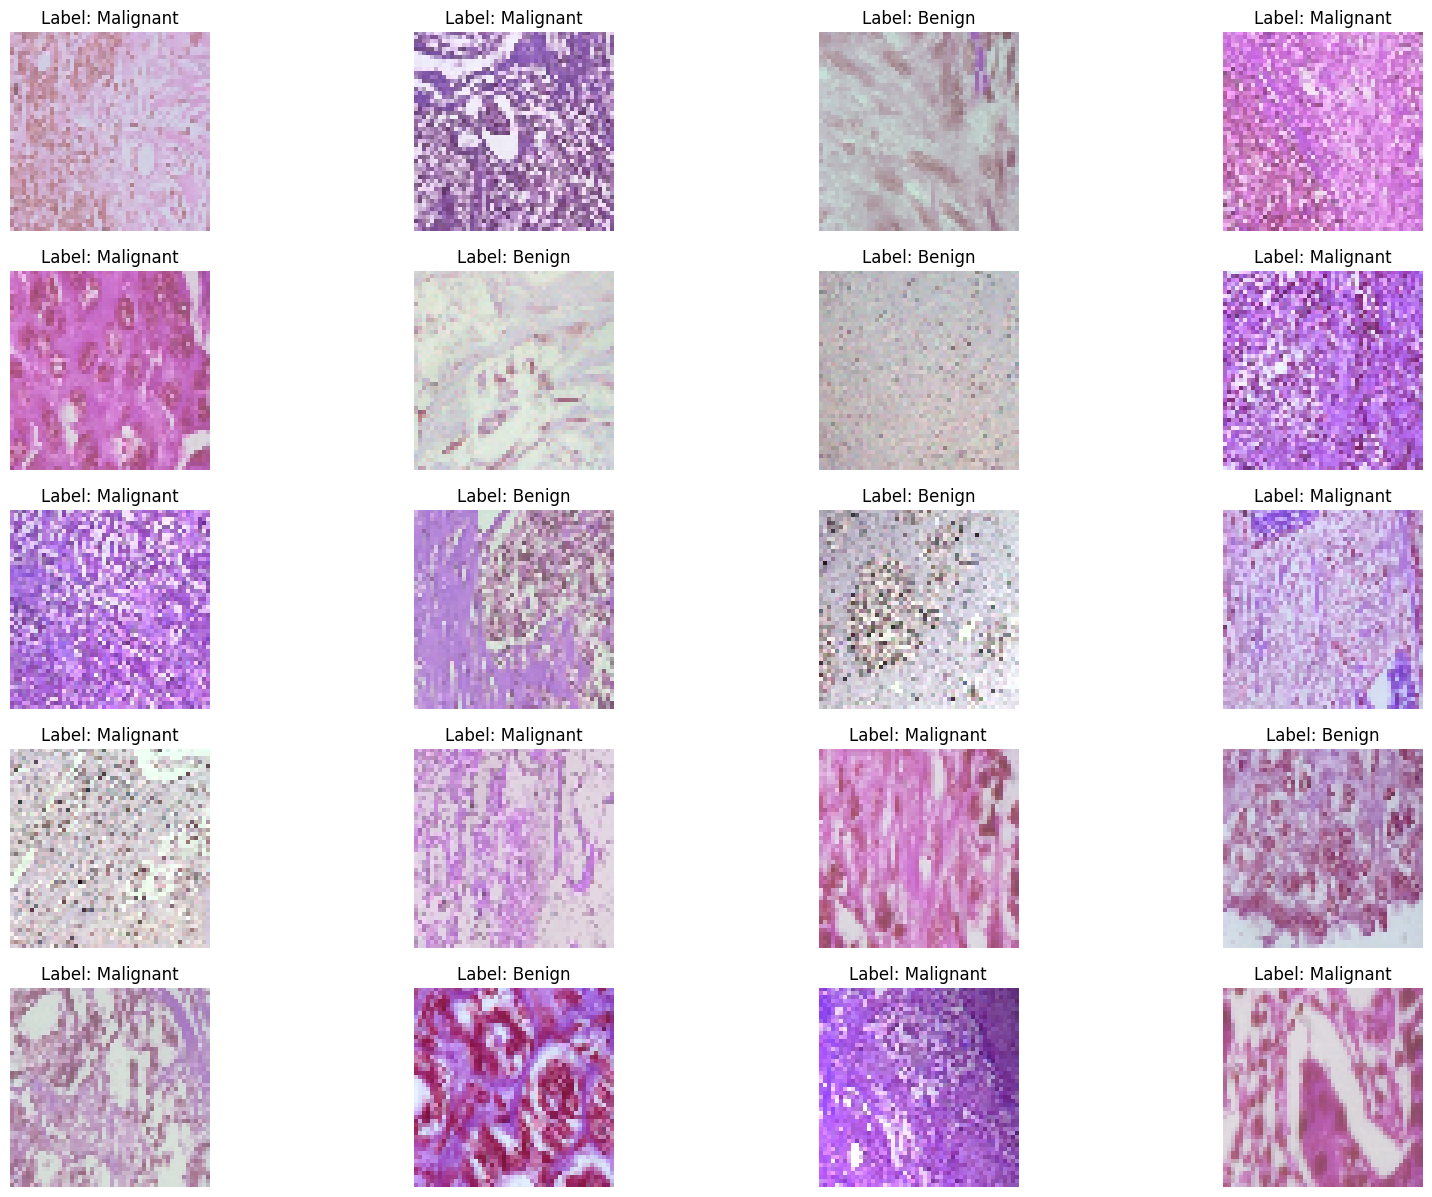

In [15]:
plot_images(X_train, y_train, ['Benign', 'Malignant'])

#### 2.2. Duplicated Images <a class="anchor" id="p22"></a>

Number of duplicate images: 39


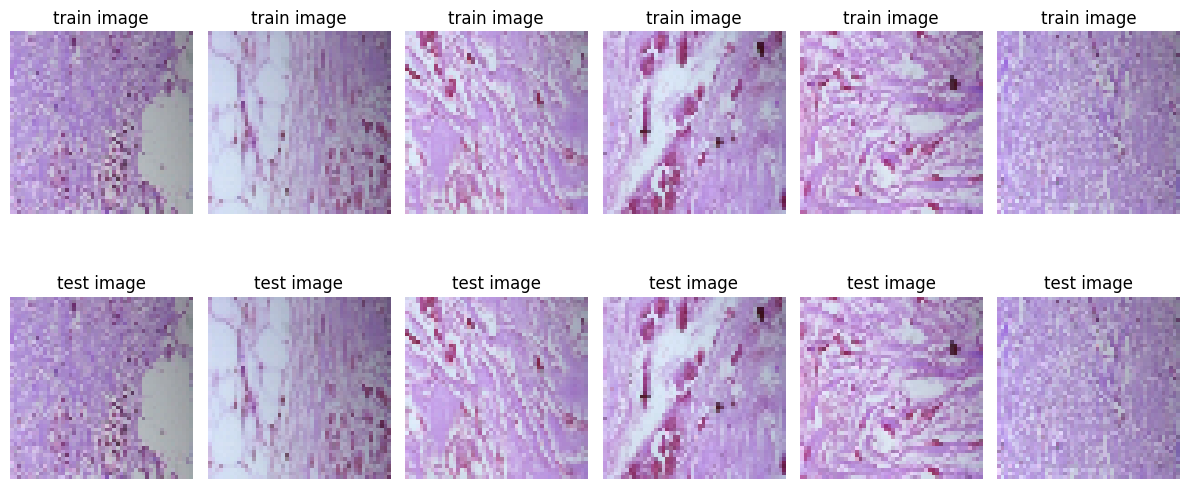

In [16]:
plot_duplicates(X_train, X_test)

In [17]:
X_train, y_train, w_train, X_test, y_test, w_test = drop_duplicates(X_train, y_train, w_train, X_test, y_test, w_test)

Updated train images shape: (6288, 50, 50, 3)
Updated test images shape: (1543, 50, 50, 3)


#### 2.3. Color Transformation and Normalization <a class="anchor" id="p23"></a>

##### 2.3.1. Gray Scaling

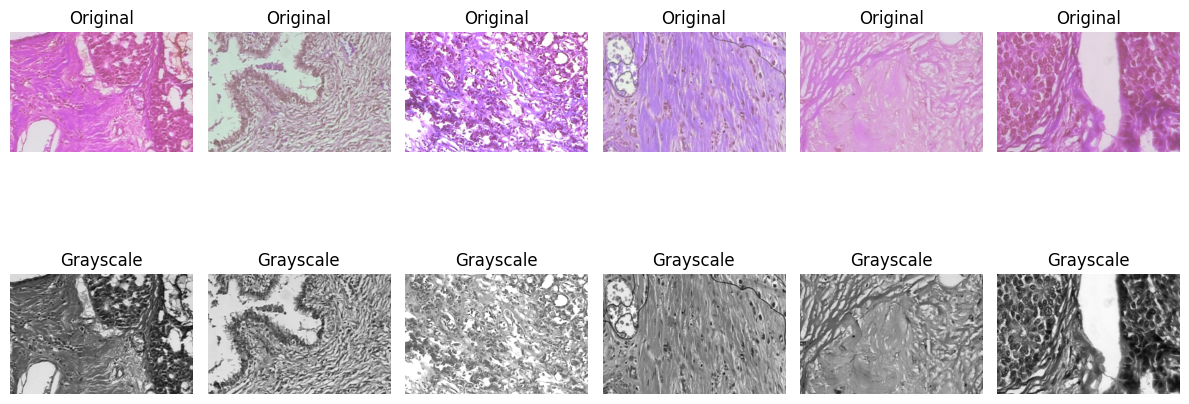

In [18]:
sample_images = train['path_to_image'].sample(n=6, random_state=42)  

plot_images_transformed(sample_images, 'gray scaling')


In [19]:
X_train_gs, y_train_gs, w_train_gs = load_images_and_labels(train, 'gray scaling')
X_test_gs, y_test_gs, w_test_gs = load_images_and_labels(test, 'gray scaling')

X_train_gs = X_train_gs.reshape((X_train_gs.shape[0], 50, 50, 1))
X_test_gs = X_test_gs.reshape((X_test_gs.shape[0], 50, 50, 1)) 

print("Train images shape:", X_train_gs.shape)
print("Train labels shape:", y_train_gs.shape)
print("Test images shape:", X_test_gs.shape)
print("Test labels shape:", y_test_gs.shape)

Train images shape: (6327, 50, 50, 1)
Train labels shape: (6327,)
Test images shape: (1582, 50, 50, 1)
Test labels shape: (1582,)


In [20]:
X_train_gs, y_train_gs, w_train_gs, X_test_gs, y_test_gs, w_test_gs = drop_duplicates(X_train_gs, y_train_gs, w_train_gs, 
                                                                                      X_test_gs, y_test_gs, w_test_gs)

Updated train images shape: (6288, 50, 50, 1)
Updated test images shape: (1543, 50, 50, 1)


##### 2.3.2. RGB Normalization

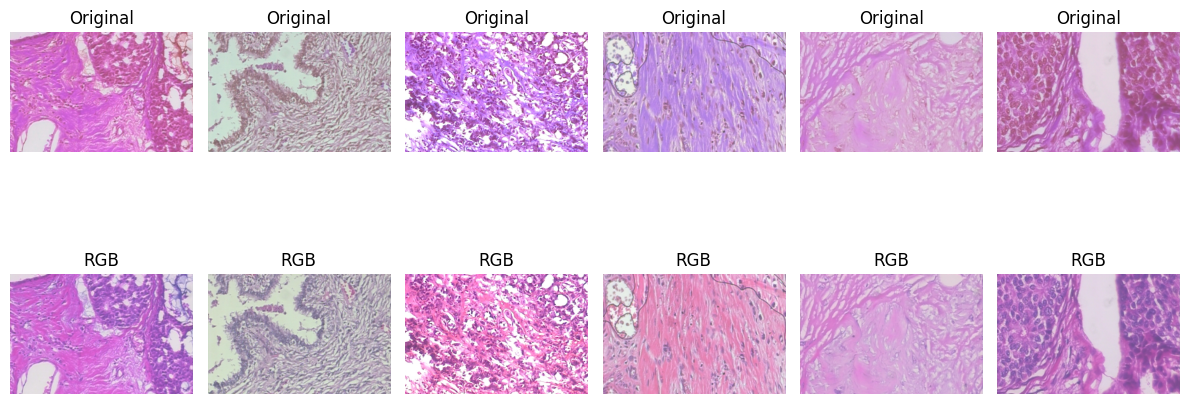

In [21]:
plot_images_transformed(sample_images, 'rgb')

In [22]:
X_train_rgb, y_train_rgb, w_train_rgb = load_images_and_labels(train, 'rgb')
X_test_rgb, y_test_rgb, w_test_rgb = load_images_and_labels(test, 'rgb')

print("Train images shape:", X_train_rgb.shape)
print("Train labels shape:", y_train_rgb.shape)
print("Test images shape:", X_test_rgb.shape)
print("Test labels shape:", y_test_rgb.shape)

Train images shape: (6327, 50, 50, 3)
Train labels shape: (6327,)
Test images shape: (1582, 50, 50, 3)
Test labels shape: (1582,)


In [23]:
X_train_rgb, y_train_rgb, w_train_rgb, X_test_rgb, y_test_rgb, w_test_rgb = drop_duplicates(X_train_rgb, y_train_rgb, w_train_rgb, 
                                                                                            X_test_rgb, y_test_rgb, w_test_rgb)

Updated train images shape: (6288, 50, 50, 3)
Updated test images shape: (1543, 50, 50, 3)


##### 2.3.3. Contrast Adjustment

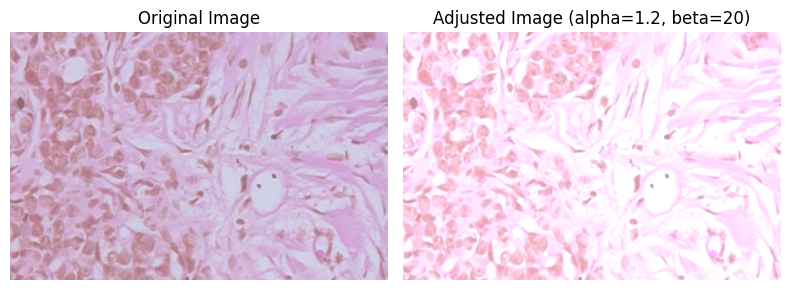

In [24]:
sample_image_path = train['path_to_image'].iloc[0]

plot_image_contrast_adjustment(sample_image_path)

In [25]:
X_train_ca, y_train_ca, w_train_ca = load_images_and_labels(train, 'contrast adjustment')
X_test_ca, y_test_ca, w_test_ca = load_images_and_labels(test, 'contrast adjustment')

print("Train images shape:", X_train_ca.shape)
print("Train labels shape:", y_train_ca.shape)
print("Test images shape:", X_test_ca.shape)
print("Test labels shape:", y_test_ca.shape)

Train images shape: (6327, 50, 50, 3)
Train labels shape: (6327,)
Test images shape: (1582, 50, 50, 3)
Test labels shape: (1582,)


In [26]:
X_train_ca, y_train_ca, w_train_ca, X_test_ca, y_test_ca, w_test_ca = drop_duplicates(X_train_ca, y_train_ca, w_train_ca, 
                                                                                      X_test_ca, y_test_ca, w_test_ca)

Updated train images shape: (6288, 50, 50, 3)
Updated test images shape: (1543, 50, 50, 3)


##### 2.3.4. Laplacian Transformation

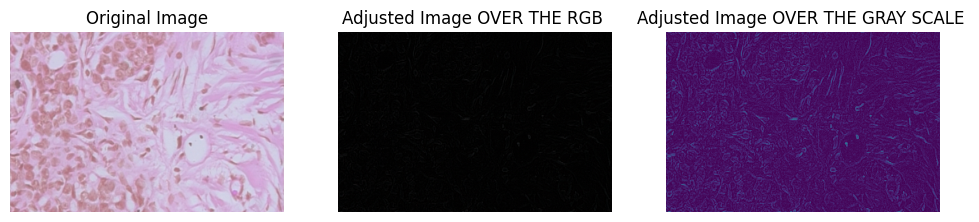

In [27]:
plot_image_laplacian_transformation(sample_image_path)

In [28]:
X_train_l , y_train_l, w_train_l = load_images_and_labels(train, 'laplacian over rgb')
X_test_l, y_test_l, w_test_l = load_images_and_labels(test, 'laplacian over rgb')

print("Train images shape:", X_train_l.shape)
print("Train labels shape:", y_train_l.shape)
print("Test images shape:", X_test_l.shape)
print("Test labels shape:", y_test_l.shape)

Train images shape: (6327, 50, 50, 3)
Train labels shape: (6327,)
Test images shape: (1582, 50, 50, 3)
Test labels shape: (1582,)


In [29]:
X_train_l , y_train_l, w_train_l, X_test_l, y_test_l, w_test_l = drop_duplicates(X_train_l , y_train_l, w_train_l,
                                                                                 X_test_l, y_test_l, w_test_l)

Updated train images shape: (6288, 50, 50, 3)
Updated test images shape: (1543, 50, 50, 3)


In [30]:
X_train_l_gs , y_train_l_gs, w_train_l_gs = load_images_and_labels(train, 'laplacian over gray')
X_test_l_gs, y_test_l_gs, w_test_l_gs = load_images_and_labels(test, 'laplacian over gray')

X_train_l_gs = X_train_l_gs.reshape((X_train_l_gs.shape[0], 50, 50, 1)) 
X_test_l_gs = X_test_l_gs.reshape((X_test_l_gs.shape[0], 50, 50, 1))  

print("Train images shape:", X_train_l_gs.shape)
print("Train labels shape:", y_train_l_gs.shape)
print("Test images shape:", X_test_l_gs.shape)
print("Test labels shape:", y_test_l_gs.shape)

Train images shape: (6327, 50, 50, 1)
Train labels shape: (6327,)
Test images shape: (1582, 50, 50, 1)
Test labels shape: (1582,)


In [31]:
X_train_l_gs , y_train_l_gs, w_train_l_gs, X_test_l_gs, y_test_l_gs, w_test_l_gs = drop_duplicates(X_train_l_gs , y_train_l_gs, 
                                                                                                   w_train_l_gs, X_test_l_gs, 
                                                                                                   y_test_l_gs, w_test_l_gs)

Updated train images shape: (6288, 50, 50, 1)
Updated test images shape: (1543, 50, 50, 1)


#### 2.3. Data Augmentation <a class="anchor" id="p24"></a>

##### 2.3.1. For Binary Classification

In [32]:
train, val = data_augmentation(X_train, y_train)

In [33]:
train_rgb, val_rgb = data_augmentation(X_train_rgb, y_train_rgb)

In [34]:
train_gs, val_gs = data_augmentation(X_train_gs, y_train_gs)

In [35]:
train_ca, val_ca = data_augmentation(X_train_ca, y_train_ca)

In [36]:
train_laplacian, val_laplacian = data_augmentation(X_train_l, y_train_l)

In [37]:
train_laplacian_gs, val_laplacian_gs = data_augmentation(X_train_l_gs, y_train_l_gs)

##### 2.3.1. For Multiclass Classification

In [38]:
train_m, val_m = data_augmentation(X_train, w_train)

In [39]:
train_rgb_m, val_rgb_m = data_augmentation(X_train_rgb, w_train_rgb)

In [40]:
train_ca_m, val_ca_m = data_augmentation(X_train_ca, w_train_ca)

## 3. Stage 1: Binary Classification  <a class="anchor" id="p3"></a>
  
[Back to TOC](#toc)

We are only classifying images as "Benign" (0) or "Malignant" (1).

#### 3.1. Base Models <a class="anchor" id="p31"></a>

In [41]:
base_model_ResNet50 = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

In [42]:
base_model_VGG16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

In [43]:
for layer in base_model_ResNet50.layers:
    layer.trainable = False
for layer in base_model_VGG16.layers:
    layer.trainable = False

#### 3.2. Callbacks <a class="anchor" id="p32"></a>

In [44]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


#### 3.3. Hypertuning the models <a class="anchor" id="p33"></a>

In [45]:
def build_model_vgg16(hp):
    return build_on_base_model(hp, base_model_VGG16)

In [46]:
def build_model_resnet50(hp):
    return build_on_base_model(hp, base_model_ResNet50)

##### 3.3.1. Model from scratch with no scaling

In [47]:
model_no_scaling, best_hp = run_tuner(build_model_from_scratch, 'no_scaling', train, val, stop_early)

print(best_hp.values)

Reloading Tuner from log\no_scaling\tuner0.json
{'filters_block1': 32, 'kernel_size_block1': 3, 'num_conv_blocks': 1, 'num_dense_layers': 4, 'dense_units_1': 32, 'dropout_dense_1': 0.30000000000000004, 'learning_rate': 0.0001, 'filters_block2': 96, 'kernel_size_block2': 3, 'filters_block3': 128, 'kernel_size_block3': 3, 'filters_block4': 96, 'kernel_size_block4': 3, 'dense_units_2': 32, 'dropout_dense_2': 0.2, 'dense_units_3': 192, 'dropout_dense_3': 0.2, 'dense_units_4': 160, 'dropout_dense_4': 0.4, 'dense_units_5': 224, 'dropout_dense_5': 0.4, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [48]:
num_epochs = best_hp.values.get('tuner/epochs')
history1 = model_no_scaling.fit(train, epochs=num_epochs, validation_data=val,verbose=1)

Epoch 1/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - auc: 0.7412 - loss: 0.6324 - val_auc: 0.8851 - val_loss: 0.5114
Epoch 2/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - auc: 0.8640 - loss: 0.5270 - val_auc: 0.8917 - val_loss: 0.4876
Epoch 3/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - auc: 0.8690 - loss: 0.5191 - val_auc: 0.8943 - val_loss: 0.4974
Epoch 4/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - auc: 0.8896 - loss: 0.4940 - val_auc: 0.8983 - val_loss: 0.4647
Epoch 5/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - auc: 0.8839 - loss: 0.4847 - val_auc: 0.9024 - val_loss: 0.4453
Epoch 6/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - auc: 0.9073 - loss: 0.4404 - val_auc: 0.9037 - val_loss: 0.4385
Epoch 7/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - auc: 0.8981 - loss: 0.4460 - val_auc: 0.9053 - val_loss: 0.4608
Epoch 8/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - auc: 0.8888 - loss: 0.4531 - val_auc: 0.9087 - val_loss: 0.4239
Epoch 9/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/

##### 3.3.2. Model from scratch with rgb 

In [49]:
model_rgb, best_hp = run_tuner(build_model_from_scratch, 'rgb', train_rgb, val_rgb, stop_early)

print(best_hp.values)

Reloading Tuner from log\rgb\tuner0.json
{'filters_block1': 32, 'kernel_size_block1': 3, 'num_conv_blocks': 1, 'num_dense_layers': 3, 'dense_units_1': 224, 'dropout_dense_1': 0.4, 'learning_rate': 0.001, 'filters_block2': 128, 'kernel_size_block2': 3, 'filters_block3': 32, 'kernel_size_block3': 3, 'dense_units_2': 256, 'dropout_dense_2': 0.5, 'dense_units_3': 192, 'dropout_dense_3': 0.2, 'dense_units_4': 32, 'dropout_dense_4': 0.4, 'dense_units_5': 256, 'dropout_dense_5': 0.5, 'filters_block4': 32, 'kernel_size_block4': 5, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0016'}


In [50]:
num_epochs = best_hp.values.get('tuner/epochs')
history2 = model_rgb.fit(train_rgb, epochs=num_epochs, validation_data=val_rgb,verbose=1)

Epoch 1/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - auc: 0.7917 - loss: 0.5991 - val_auc: 0.8831 - val_loss: 0.4933
Epoch 2/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - auc: 0.8555 - loss: 0.4971 - val_auc: 0.8922 - val_loss: 0.4429
Epoch 3/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - auc: 0.8815 - loss: 0.4586 - val_auc: 0.8939 - val_loss: 0.4692
Epoch 4/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - auc: 0.8843 - loss: 0.4488 - val_auc: 0.9086 - val_loss: 0.4126
Epoch 5/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - auc: 0.9036 - loss: 0.4187 - val_auc: 0.8963 - val_loss: 0.4309
Epoch 6/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - auc: 0.8803 - loss: 0.4460 - val_auc: 0.8942 - val_loss: 0.4272
Epoch 7/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - auc: 0.8981 - loss: 0.4032 - val_auc: 0.9009 - val_loss: 0.4110
Epoch 8/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - auc: 0.8928 - loss: 0.4211 - val_auc: 0.9012 - val_loss: 0.4448
Epoch 9/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms

##### 3.3.3. Model from scratch with gray scaling

In [51]:
model_gs, best_hp = run_tuner(build_model_from_scratch_gray_scaling, 'gs',train_gs, val_gs,  stop_early)

print(best_hp.values)

Reloading Tuner from log\gs\tuner0.json
{'filters_block1': 16, 'kernel_size_block1': 3, 'num_conv_blocks': 2, 'filters_block2': 64, 'kernel_size_block2': 3, 'num_dense_layers': 1, 'dense_units_1': 32, 'dropout_dense_1': 0.4, 'learning_rate': 0.001, 'filters_block3': 64, 'kernel_size_block3': 5, 'dense_units_2': 160, 'dropout_dense_2': 0.4, 'dense_units_3': 64, 'dropout_dense_3': 0.5, 'filters_block4': 96, 'kernel_size_block4': 5, 'tuner/epochs': 7, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}


In [52]:
num_epochs = best_hp.values.get('tuner/epochs')
history3 = model_gs.fit(train_gs, epochs=num_epochs, validation_data=val_gs,verbose=1)

Epoch 1/7
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - auc: 0.6690 - loss: 0.6468 - val_auc: 0.6244 - val_loss: 0.6269
Epoch 2/7
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - auc: 0.6889 - loss: 0.6309 - val_auc: 0.6257 - val_loss: 0.6212
Epoch 3/7
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - auc: 0.6798 - loss: 0.6336 - val_auc: 0.6397 - val_loss: 0.6207
Epoch 4/7
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - auc: 0.6694 - loss: 0.6358 - val_auc: 0.7139 - val_loss: 0.6218
Epoch 5/7
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - auc: 0.6963 - loss: 0.6237 - val_auc: 0.7311 - val_loss: 0.6223
Epoch 6/7
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - auc: 0.6844 - loss: 0.6297 - val_auc: 0.7241 - val_loss: 0.6186
Epoch 7/7
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - auc: 0.7019 - loss: 0.6246 - val_auc: 0.7571 - val_loss: 0.6174


##### 3.3.4. Model from scratch with Contrast Adjustment

In [53]:
model_ca, best_hp = run_tuner(build_model_from_scratch, 'ca', train_ca, val_ca, stop_early)

print(best_hp.values)

Reloading Tuner from log\ca\tuner0.json
{'filters_block1': 32, 'kernel_size_block1': 3, 'num_conv_blocks': 1, 'num_dense_layers': 5, 'dense_units_1': 96, 'dropout_dense_1': 0.2, 'learning_rate': 0.0001, 'filters_block2': 128, 'kernel_size_block2': 3, 'filters_block3': 32, 'kernel_size_block3': 3, 'dense_units_2': 224, 'dropout_dense_2': 0.30000000000000004, 'dense_units_3': 32, 'dropout_dense_3': 0.2, 'dense_units_4': 160, 'dropout_dense_4': 0.2, 'filters_block4': 32, 'kernel_size_block4': 3, 'dense_units_5': 256, 'dropout_dense_5': 0.5, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [54]:
num_epochs = best_hp.values.get('tuner/epochs')
history4 = model_ca.fit(train_ca, epochs=num_epochs, validation_data=val_ca,verbose=1)

Epoch 1/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - auc: 0.7040 - loss: 0.6503 - val_auc: 0.8671 - val_loss: 0.5487
Epoch 2/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - auc: 0.8539 - loss: 0.5502 - val_auc: 0.8753 - val_loss: 0.5176
Epoch 3/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - auc: 0.8694 - loss: 0.5306 - val_auc: 0.8834 - val_loss: 0.5035
Epoch 4/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - auc: 0.8668 - loss: 0.5260 - val_auc: 0.8862 - val_loss: 0.4944
Epoch 5/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - auc: 0.8865 - loss: 0.4955 - val_auc: 0.8869 - val_loss: 0.5294
Epoch 6/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - auc: 0.8768 - loss: 0.5001 - val_auc: 0.8970 - val_loss: 0.4684
Epoch 7/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - auc: 0.8574 - loss: 0.5073 - val_auc: 0.9000 - val_loss: 0.4420
Epoch 8/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - auc: 0.8793 - loss: 0.4769 - val_auc: 0.9021 - val_loss: 0.4587
Epoch 9/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/

##### 3.3.5. Model from scratch with Laplacian Transformation

In [55]:
model_laplacian, best_hp = run_tuner(build_model_from_scratch, 'laplacian', train_laplacian, val_laplacian, stop_early)

print(best_hp.values)

Reloading Tuner from log\laplacian\tuner0.json
{'filters_block1': 32, 'kernel_size_block1': 3, 'num_conv_blocks': 0, 'num_dense_layers': 2, 'dense_units_1': 128, 'dropout_dense_1': 0.2, 'learning_rate': 0.001, 'filters_block2': 96, 'kernel_size_block2': 5, 'filters_block3': 32, 'kernel_size_block3': 5, 'dense_units_2': 32, 'dropout_dense_2': 0.5, 'dense_units_3': 160, 'dropout_dense_3': 0.2, 'dense_units_4': 160, 'dropout_dense_4': 0.2, 'filters_block4': 96, 'kernel_size_block4': 3, 'dense_units_5': 64, 'dropout_dense_5': 0.2, 'tuner/epochs': 7, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}


In [56]:
num_epochs = best_hp.values.get('tuner/epochs')
history5 = model_laplacian.fit(train_laplacian, epochs=num_epochs, validation_data=val_laplacian,verbose=1)

Epoch 1/7
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - auc: 0.6685 - loss: 0.6946 - val_auc: 0.7313 - val_loss: 0.6353
Epoch 2/7
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - auc: 0.7040 - loss: 0.6294 - val_auc: 0.7510 - val_loss: 0.6193
Epoch 3/7
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - auc: 0.7338 - loss: 0.6197 - val_auc: 0.7801 - val_loss: 0.6112
Epoch 4/7
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - auc: 0.7488 - loss: 0.6165 - val_auc: 0.7919 - val_loss: 0.5973
Epoch 5/7
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - auc: 0.7735 - loss: 0.6012 - val_auc: 0.8048 - val_loss: 0.5898
Epoch 6/7
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - auc: 0.8019 - loss: 0.5908 - val_auc: 0.8208 - val_loss: 0.6006
Epoch 7/7
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - auc: 0.8245 - loss: 0.5744 - val_auc: 0.8374 - val_loss: 0.5686


##### 3.3.5. Model from scratch with Laplacian Transformation over Gray Scaling

In [57]:
model_laplacian_gs, best_hp = run_tuner(build_model_from_scratch_gray_scaling, 'laplacian_gs', train_laplacian_gs, 
                                        val_laplacian_gs,  stop_early)

print(best_hp.values)

Reloading Tuner from log\laplacian_gs\tuner0.json
{'filters_block1': 16, 'kernel_size_block1': 3, 'num_conv_blocks': 1, 'filters_block2': 128, 'kernel_size_block2': 3, 'num_dense_layers': 2, 'dense_units_1': 32, 'dropout_dense_1': 0.4, 'learning_rate': 0.0001, 'filters_block3': 32, 'kernel_size_block3': 3, 'dense_units_2': 128, 'dropout_dense_2': 0.5, 'filters_block4': 64, 'kernel_size_block4': 5, 'dense_units_3': 32, 'dropout_dense_3': 0.2, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [58]:
num_epochs = best_hp.values.get('tuner/epochs')
history6 = model_laplacian_gs.fit(train_laplacian_gs, epochs=num_epochs, validation_data=val_laplacian_gs,verbose=1)

Epoch 1/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - auc: 0.6693 - loss: 0.6585 - val_auc: 0.6814 - val_loss: 0.6247
Epoch 2/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - auc: 0.6669 - loss: 0.6496 - val_auc: 0.6861 - val_loss: 0.6237
Epoch 3/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - auc: 0.6959 - loss: 0.6301 - val_auc: 0.6946 - val_loss: 0.6285
Epoch 4/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - auc: 0.7024 - loss: 0.6306 - val_auc: 0.6993 - val_loss: 0.6201
Epoch 5/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - auc: 0.7039 - loss: 0.6267 - val_auc: 0.7335 - val_loss: 0.6193
Epoch 6/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - auc: 0.7045 - loss: 0.6296 - val_auc: 0.7463 - val_loss: 0.6139
Epoch 7/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - auc: 0.7122 - loss: 0.6263 - val_auc: 0.8001 - val_loss: 0.6136
Epoch 8/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - auc: 0.7156 - loss: 0.6247 - val_auc: 0.8023 - val_loss: 0.6064
Epoch 9/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/

##### 3.3.6. VGG16 with no scaling

In [59]:
vgg16_no_scaling, best_hp = run_tuner(build_model_vgg16,'vgg16_no_scaling', train, val, stop_early)

print(best_hp.values)

Reloading Tuner from log\vgg16_no_scaling\tuner0.json
{'num_layers': 3, 'units_1': 96, 'dropout_1': 0.30000000000000004, 'learning_rate': 0.001, 'units_2': 640, 'dropout_2': 0.2, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0013', 'units_3': 416, 'dropout_3': 0.5, 'units_4': 704, 'dropout_4': 0.2, 'units_5': 576, 'dropout_5': 0.4}


In [60]:
num_epochs = best_hp.values.get('tuner/epochs')
history7 = vgg16_no_scaling.fit(train, epochs=num_epochs, validation_data=val,verbose=1)

Epoch 1/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 31s 186ms/step - auc: 0.8263 - loss: 0.5622 - val_auc: 0.8848 - val_loss: 0.4752
Epoch 2/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 29s 184ms/step - auc: 0.8743 - loss: 0.4972 - val_auc: 0.8976 - val_loss: 0.4641
Epoch 3/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 29s 185ms/step - auc: 0.8817 - loss: 0.4855 - val_auc: 0.9036 - val_loss: 0.4529
Epoch 4/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 29s 184ms/step - auc: 0.8967 - loss: 0.4721 - val_auc: 0.9048 - val_loss: 0.4580
Epoch 5/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 29s 184ms/step - auc: 0.9013 - loss: 0.4569 - val_auc: 0.9024 - val_loss: 0.4595
Epoch 6/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 31s 195ms/step - auc: 0.9082 - loss: 0.4579 - val_auc: 0.9110 - val_loss: 0.4382
Epoch 7/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 30s 189ms/step - auc: 0.9047 - loss: 0.4559 - val_auc: 0.9039 - val_loss: 0.4476
Epoch 8/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 30s 187ms/step - auc: 0.9078 - loss: 0.4543 - val_auc: 0.8991 - val_loss: 0.4566
Epoch 9/20
158/158 ━━━━━━━━━━━━━

##### 3.3.7. VGG16 with RGB Scaling

In [61]:
vgg16_rgb, best_hp = run_tuner(build_model_vgg16,'vgg16_rgb', train_rgb, val_rgb, stop_early)

print(best_hp.values)

Reloading Tuner from log\vgg16_rgb\tuner0.json
{'num_layers': 3, 'units_1': 704, 'dropout_1': 0.2, 'learning_rate': 0.001, 'units_2': 576, 'dropout_2': 0.30000000000000004, 'units_3': 768, 'dropout_3': 0.30000000000000004, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0012'}


In [62]:
num_epochs = best_hp.values.get('tuner/epochs')
history8 = vgg16_rgb.fit(train_rgb, epochs=num_epochs, validation_data=val_rgb,verbose=1)

Epoch 1/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 31s 188ms/step - auc: 0.8217 - loss: 0.5722 - val_auc: 0.9013 - val_loss: 0.4468
Epoch 2/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 29s 185ms/step - auc: 0.8931 - loss: 0.4746 - val_auc: 0.9091 - val_loss: 0.4334
Epoch 3/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 29s 185ms/step - auc: 0.8998 - loss: 0.4562 - val_auc: 0.9296 - val_loss: 0.4168
Epoch 4/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 30s 187ms/step - auc: 0.9205 - loss: 0.4220 - val_auc: 0.9217 - val_loss: 0.4265
Epoch 5/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 100s 638ms/step - auc: 0.9147 - loss: 0.4343 - val_auc: 0.9258 - val_loss: 0.4323
Epoch 6/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 39s 247ms/step - auc: 0.9107 - loss: 0.4294 - val_auc: 0.9241 - val_loss: 0.4223
Epoch 7/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 34s 216ms/step - auc: 0.9222 - loss: 0.4229 - val_auc: 0.9175 - val_loss: 0.4497
Epoch 8/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 29s 186ms/step - auc: 0.9214 - loss: 0.4268 - val_auc: 0.9278 - val_loss: 0.4035
Epoch 9/20
158/158 ━━━━━━━━━━━━

##### 3.3.9. ResNet50 with no scaling

In [63]:
resnet50_no_scaling, best_hp = run_tuner(build_model_resnet50,'resnet50_no_scaling', train, val, stop_early)

print(best_hp.values)

Reloading Tuner from log\resnet50_no_scaling\tuner0.json
{'num_layers': 2, 'units_1': 256, 'dropout_1': 0.2, 'learning_rate': 0.001, 'units_2': 320, 'dropout_2': 0.5, 'units_3': 512, 'dropout_3': 0.5, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0013'}


In [64]:
num_epochs = best_hp.values.get('tuner/epochs')
history9 = resnet50_no_scaling.fit(train, epochs=num_epochs, validation_data=val,verbose=1)

Epoch 1/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 30s 160ms/step - auc: 0.6809 - loss: 0.7001 - val_auc: 0.7763 - val_loss: 0.6178
Epoch 2/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 24s 151ms/step - auc: 0.7124 - loss: 0.6279 - val_auc: 0.7926 - val_loss: 0.6217
Epoch 3/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 24s 152ms/step - auc: 0.7241 - loss: 0.6221 - val_auc: 0.8130 - val_loss: 0.6058
Epoch 4/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - auc: 0.7443 - loss: 0.6161 - val_auc: 0.8149 - val_loss: 0.6203
Epoch 5/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 24s 152ms/step - auc: 0.7238 - loss: 0.6292 - val_auc: 0.8146 - val_loss: 0.6052
Epoch 6/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 24s 152ms/step - auc: 0.7570 - loss: 0.6183 - val_auc: 0.8207 - val_loss: 0.6023
Epoch 7/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 24s 151ms/step - auc: 0.7808 - loss: 0.6081 - val_auc: 0.8298 - val_loss: 0.6288
Epoch 8/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 24s 152ms/step - auc: 0.7905 - loss: 0.5966 - val_auc: 0.8385 - val_loss: 0.5949
Epoch 9/20
158/158 ━━━━━━━━━━━━━

##### 3.3.10. ResNet50 with RGB Scaling

In [65]:
resnet50_rgb, best_hp = run_tuner(build_model_resnet50,'resnet50_rgb', train_rgb, val_rgb, stop_early)

print(best_hp.values)

Reloading Tuner from log\resnet50_rgb\tuner0.json
{'num_layers': 2, 'units_1': 640, 'dropout_1': 0.30000000000000004, 'learning_rate': 0.001, 'units_2': 576, 'dropout_2': 0.2, 'units_3': 448, 'dropout_3': 0.5, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0021'}


In [66]:
num_epochs = best_hp.values.get('tuner/epochs')
history10 = resnet50_rgb.fit(train_rgb, epochs=num_epochs, validation_data=val_rgb,verbose=1)

Epoch 1/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 32s 178ms/step - auc: 0.7087 - loss: 0.7635 - val_auc: 0.8049 - val_loss: 0.6205
Epoch 2/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 27s 170ms/step - auc: 0.7422 - loss: 0.6172 - val_auc: 0.8089 - val_loss: 0.6110
Epoch 3/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 27s 170ms/step - auc: 0.7355 - loss: 0.6177 - val_auc: 0.8079 - val_loss: 0.6146
Epoch 4/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 27s 171ms/step - auc: 0.7173 - loss: 0.6282 - val_auc: 0.8161 - val_loss: 0.6100
Epoch 5/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 27s 169ms/step - auc: 0.7471 - loss: 0.6145 - val_auc: 0.7998 - val_loss: 0.6202
Epoch 6/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 27s 170ms/step - auc: 0.7512 - loss: 0.6226 - val_auc: 0.8233 - val_loss: 0.6027
Epoch 7/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 27s 171ms/step - auc: 0.7527 - loss: 0.6158 - val_auc: 0.8327 - val_loss: 0.5969
Epoch 8/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 27s 170ms/step - auc: 0.7593 - loss: 0.6137 - val_auc: 0.8367 - val_loss: 0.6204
Epoch 9/20
158/158 ━━━━━━━━━━━━━

#### 3.4. Model Evaluation <a class="anchor" id="p34"></a>

##### 3.4.1. Validation Scores

In [67]:
binary_histories = [history1, history2, history3, history4, history5, history6, history7, history8, history9, history10]
binary_model_names = ["No Scaling", "RGB", "Grayscale", "Contrast Adjustment", "Laplacian", "Laplacian + GS",
                      "VGG16 No Scaling", "VGG16 RGB", "ResNet50 No Scaling", "ResNet50 RGB"]

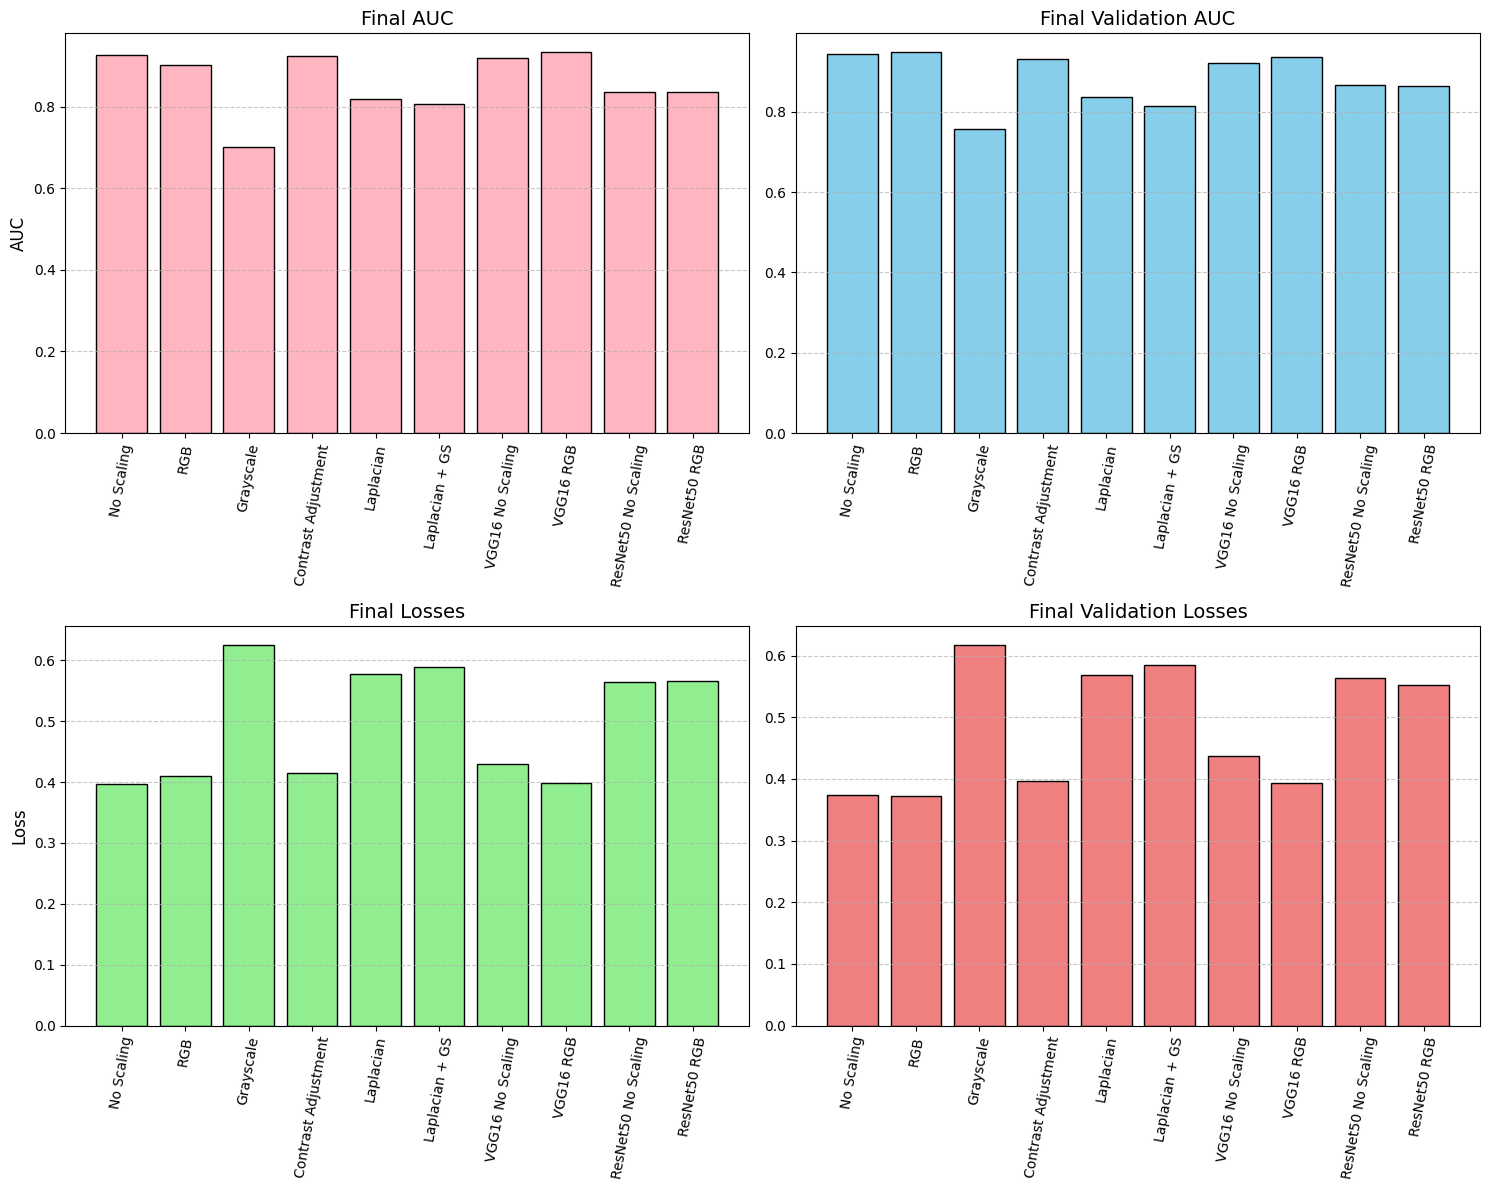

In [68]:
plot_val_scores(binary_histories, binary_model_names)

##### 3.4.2. Test Scores

In [69]:
binary_models = {model_no_scaling: [X_test, y_test],
                 model_rgb: [X_test_rgb, y_test_rgb], 
                 model_gs: [X_test_gs, y_test_gs], 
                 model_ca: [X_test_ca, y_test_ca],
                 model_laplacian: [X_test_l, y_test_l], 
                 model_laplacian_gs: [X_test_l_gs, y_test_l_gs], 
                 vgg16_no_scaling: [X_test, y_test], 
                 vgg16_rgb: [X_test_rgb, y_test_rgb],  
                 resnet50_no_scaling: [X_test, y_test], 
                 resnet50_rgb: [X_test_rgb, y_test_rgb]}

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step


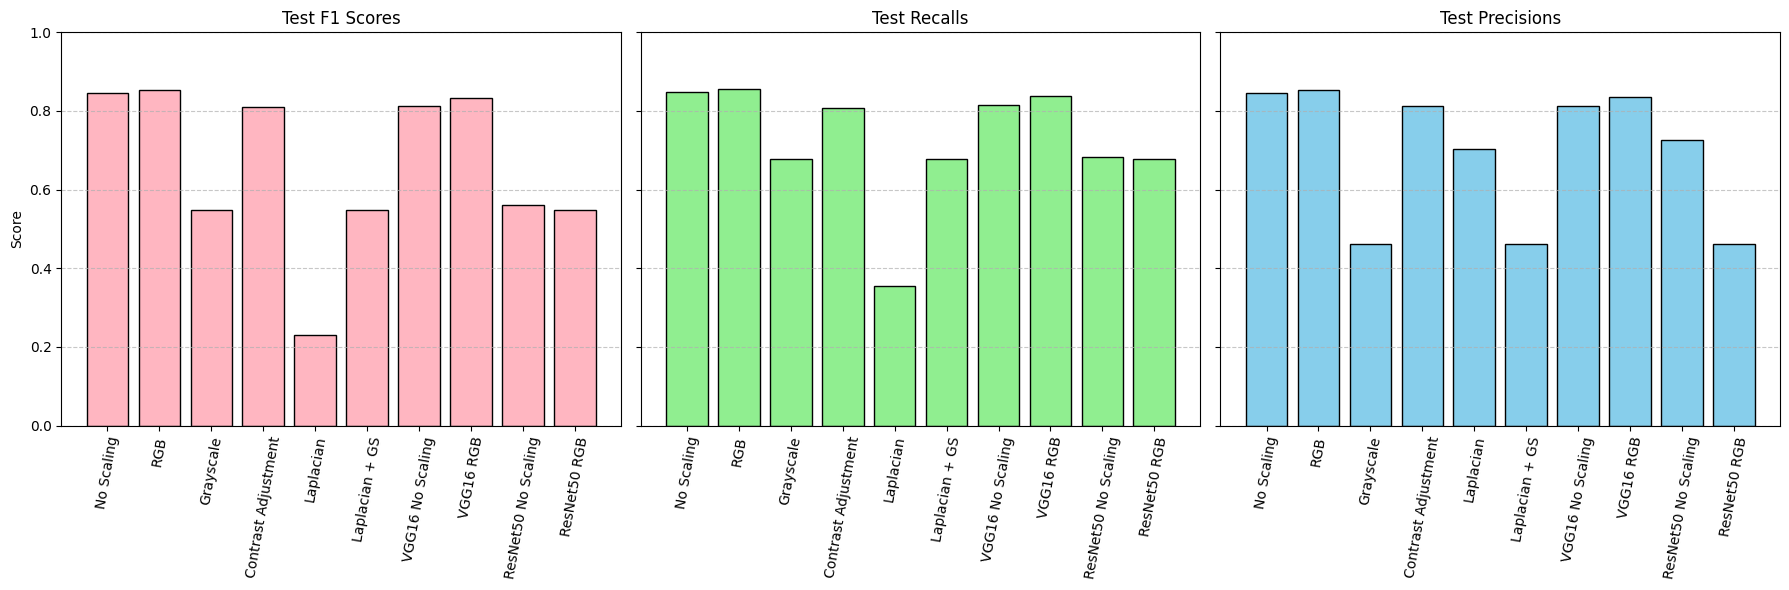

In [70]:
plot_test_scores(binary_models, binary_model_names)

#### 3.5. Final Model <a class="anchor" id="p35"></a>

In [71]:
model_rgb.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 22, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 224)            │     3,469,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        57,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 192)            │        49,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,843,685 (41.37 MB)

 Trainable params: 3,614,561 (13.79 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,229,124 (27.58 MB)

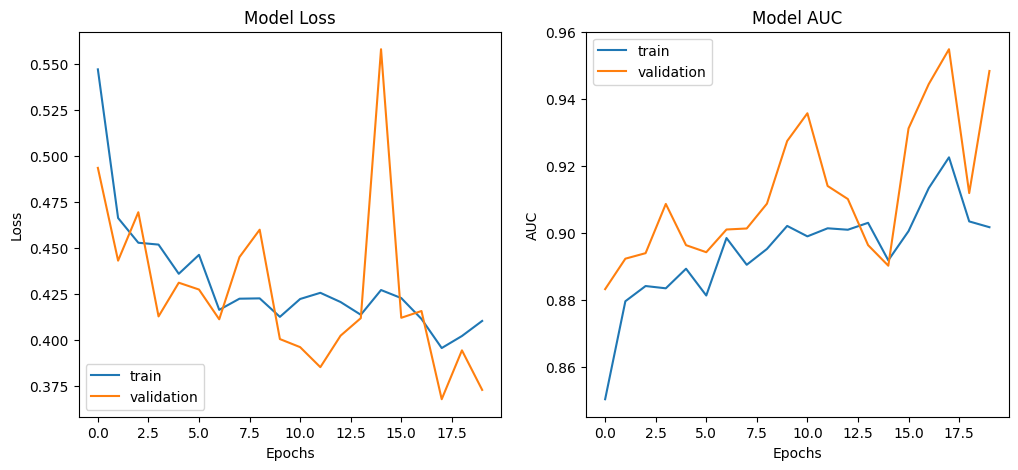

<Figure size 640x480 with 0 Axes>

In [72]:
plot_history(history2)

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


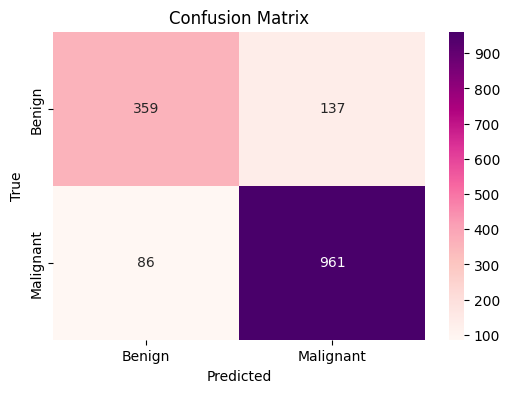

              precision    recall  f1-score   support

           0       0.81      0.72      0.76       496
           1       0.88      0.92      0.90      1047

    accuracy                           0.86      1543
   macro avg       0.84      0.82      0.83      1543
weighted avg       0.85      0.86      0.85      1543



In [73]:
plot_confusion_matrix(model_rgb, X_test_rgb, y_test_rgb, ["Benign", "Malignant"])

## 4. Stage 2: Multiclass Classification  <a class="anchor" id="p4"></a>
  
[Back to TOC](#toc)

#### 4.1. Class Weights <a class="anchor" id="p41"></a>

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(w_train), y=w_train)
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 2.1072386058981234,
 1: 1.7583892617449663,
 2: 2.2329545454545454,
 3: 0.28822882288228824,
 4: 1.654736842105263,
 5: 1.201834862385321,
 6: 1.7544642857142858,
 7: 0.9679802955665024}

#### 4.2. Hypertuning the models <a class="anchor" id="p42"></a>

In [ ]:
def build_multi_model_vgg16(hp):
    return build_on_base_model_multi(hp, base_model_VGG16)

##### 4.2.1.  Model from scratch with no scaling

In [ ]:
model_no_scaling_2, best_hp = run_tuner_multi(build_multi_model_from_scratch, 'no_scaling_2', train_m, val_m, stop_early)

print(best_hp.values)

Reloading Tuner from log\no_scaling_2\tuner0.json
{'filters_block1': 32, 'kernel_size_block1': 3, 'num_conv_blocks': 3, 'filters_block2': 128, 'kernel_size_block2': 3, 'num_dense_layers': 2, 'dense_units_1': 64, 'dropout_dense_1': 0.30000000000000004, 'learning_rate': 0.001, 'filters_block3': 92, 'kernel_size_block3': 3, 'filters_block4': 128, 'kernel_size_block4': 3, 'dense_units_2': 224, 'dropout_dense_2': 0.5, 'dense_units_3': 160, 'dropout_dense_3': 0.4, 'filters_block5': 92, 'kernel_size_block5': 3, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0013'}


In [ ]:
num_epochs = best_hp.values.get('tuner/epochs')
history20 = model_no_scaling_2.fit(train_m, epochs=num_epochs, validation_data=val_m ,verbose=1)

Epoch 1/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.5022 - loss: 1.5354 - val_accuracy: 0.4828 - val_loss: 1.5573
Epoch 2/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.5130 - loss: 1.5030 - val_accuracy: 0.5102 - val_loss: 1.4656
Epoch 3/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.5123 - loss: 1.4990 - val_accuracy: 0.4682 - val_loss: 1.5756
Epoch 4/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - accuracy: 0.4896 - loss: 1.5287 - val_accuracy: 0.5127 - val_loss: 1.4437
Epoch 5/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - accuracy: 0.5059 - loss: 1.4850 - val_accuracy: 0.5145 - val_loss: 1.4379
Epoch 6/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.5021 - loss: 1.4949 - val_accuracy: 0.5162 - val_loss: 1.4118
Epoch 7/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.5103 - loss: 1.4688 - val_accuracy: 0.5060 - val_loss: 1.5023
Epoch 8/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.5090 - loss: 1.4576 - 

In [ ]:
model_no_scaling_3, best_hp = run_tuner_multi(build_multi_model_from_scratch, 'no_scaling_2', train_m, val_m, stop_early)
num_epochs = best_hp.values.get('tuner/epochs')
history201 = model_no_scaling_3.fit(train_m, epochs=num_epochs, validation_data=val_m ,verbose=1, class_weight=class_weights_dict)

Reloading Tuner from log\no_scaling_2\tuner0.json
Epoch 1/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.1396 - loss: 2.1044 - val_accuracy: 0.1045 - val_loss: 1.9110
Epoch 2/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.2825 - loss: 1.9815 - val_accuracy: 0.3601 - val_loss: 1.8415
Epoch 3/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.2558 - loss: 1.9118 - val_accuracy: 0.3737 - val_loss: 1.8142
Epoch 4/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.2750 - loss: 1.9699 - val_accuracy: 0.2096 - val_loss: 1.9826
Epoch 5/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.2822 - loss: 1.9271 - val_accuracy: 0.3290 - val_loss: 1.7317
Epoch 6/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.2859 - loss: 1.8645 - val_accuracy: 0.2689 - val_loss: 1.7864
Epoch 7/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.2718 - loss: 1.8542 - val_accuracy: 0.3321 - val_loss: 1.6978
Epoch 8/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
classes = ['Adenosis', 'Tubular Adenoma', 'Phyllodes Tumor', 'Ductal Carcinoma',
           'Lobular Carcinoma', 'Mucinous Carcinoma', 'Papillary Carcinoma', 'Fibroadenoma']
plot_confusion_matrix(model_no_scaling_2, X_test, w_test, classes, False)

##### 4.2.2.  Model from scratch with RGB 

In [ ]:
model_rgb_2, best_hp = run_tuner_multi(build_multi_model_from_scratch, 'rgb_2', train_rgb_m, val_rgb_m, stop_early)

print(best_hp.values)

Reloading Tuner from log\rgb_2\tuner0.json
{'filters_block1': 64, 'kernel_size_block1': 3, 'num_conv_blocks': 2, 'filters_block2': 92, 'kernel_size_block2': 3, 'num_dense_layers': 2, 'dense_units_1': 256, 'dropout_dense_1': 0.5, 'learning_rate': 0.001, 'filters_block3': 128, 'kernel_size_block3': 3, 'dense_units_2': 128, 'dropout_dense_2': 0.5, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0012', 'filters_block4': 128, 'kernel_size_block4': 5, 'dense_units_3': 160, 'dropout_dense_3': 0.30000000000000004, 'filters_block5': 92, 'kernel_size_block5': 3}


In [ ]:
num_epochs = best_hp.values.get('tuner/epochs')
history21 = model_rgb_2.fit(train_rgb_m, epochs=num_epochs, validation_data=val_rgb_m ,verbose=1)

Epoch 1/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 18s 86ms/step - accuracy: 0.4118 - loss: 1.7877 - val_accuracy: 0.4507 - val_loss: 1.6060
Epoch 2/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.4762 - loss: 1.6188 - val_accuracy: 0.4873 - val_loss: 1.6372
Epoch 3/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.4971 - loss: 1.5734 - val_accuracy: 0.4806 - val_loss: 1.5773
Epoch 4/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.4906 - loss: 1.5655 - val_accuracy: 0.5127 - val_loss: 1.4945
Epoch 5/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.4942 - loss: 1.5586 - val_accuracy: 0.5121 - val_loss: 1.4514
Epoch 6/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.5097 - loss: 1.4851 - val_accuracy: 0.5105 - val_loss: 1.4400
Epoch 7/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.5070 - loss: 1.4893 - val_accuracy: 0.5138 - val_loss: 1.4520
Epoch 8/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.5065 - loss: 1.4851 - 

In [ ]:
model_rgb_3, best_hp = run_tuner_multi(build_multi_model_from_scratch, 'rgb_2', train_rgb_m, val_rgb_m, stop_early)
num_epochs = best_hp.values.get('tuner/epochs')
history211 = model_rgb_3.fit(train_rgb_m, epochs=num_epochs, validation_data=val_rgb_m ,verbose=1, class_weight=class_weights_dict)

Reloading Tuner from log\rgb_2\tuner0.json
Epoch 1/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 17s 76ms/step - accuracy: 0.1571 - loss: 2.0699 - val_accuracy: 0.0638 - val_loss: 2.0949
Epoch 2/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.2033 - loss: 2.0521 - val_accuracy: 0.4561 - val_loss: 1.7364
Epoch 3/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.2624 - loss: 1.9221 - val_accuracy: 0.4313 - val_loss: 1.8264
Epoch 4/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.2745 - loss: 1.9134 - val_accuracy: 0.3944 - val_loss: 1.6908
Epoch 5/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.2856 - loss: 1.8756 - val_accuracy: 0.3712 - val_loss: 1.7543
Epoch 6/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.2656 - loss: 1.8309 - val_accuracy: 0.2961 - val_loss: 1.7339
Epoch 7/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.2821 - loss: 1.8505 - val_accuracy: 0.2758 - val_loss: 1.8218
Epoch 8/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 75m

In [ ]:
plot_confusion_matrix(model_rgb_2, X_test_rgb, w_test_rgb, classes, False)

##### 4.2.3. Model from scratch with contrast adjustment

In [ ]:
model_ca_2, best_hp = run_tuner_multi(build_multi_model_from_scratch, 'ca_2', train_ca_m, val_ca_m, stop_early)

print(best_hp.values)

Reloading Tuner from log\ca_2\tuner0.json
{'filters_block1': 16, 'kernel_size_block1': 3, 'num_conv_blocks': 3, 'filters_block2': 92, 'kernel_size_block2': 5, 'num_dense_layers': 1, 'dense_units_1': 192, 'dropout_dense_1': 0.4, 'learning_rate': 0.001, 'filters_block3': 128, 'kernel_size_block3': 3, 'filters_block4': 128, 'kernel_size_block4': 5, 'filters_block5': 64, 'kernel_size_block5': 5, 'dense_units_2': 192, 'dropout_dense_2': 0.2, 'dense_units_3': 64, 'dropout_dense_3': 0.4, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0017'}


In [ ]:
num_epochs = best_hp.values.get('tuner/epochs')
history22 = model_ca_2.fit(train_ca_m, epochs=num_epochs, validation_data=val_ca_m ,verbose=1)

Epoch 1/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - accuracy: 0.4235 - loss: 1.7829 - val_accuracy: 0.4897 - val_loss: 1.5902
Epoch 2/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.4688 - loss: 1.6480 - val_accuracy: 0.4944 - val_loss: 1.5911
Epoch 3/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.4773 - loss: 1.6182 - val_accuracy: 0.4981 - val_loss: 1.5802
Epoch 4/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.4788 - loss: 1.6164 - val_accuracy: 0.4715 - val_loss: 1.6035
Epoch 5/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.4877 - loss: 1.5900 - val_accuracy: 0.4954 - val_loss: 1.5552
Epoch 6/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.4965 - loss: 1.5646 - val_accuracy: 0.4975 - val_loss: 1.5329
Epoch 7/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.4870 - loss: 1.5705 - val_accuracy: 0.4920 - val_loss: 1.5511
Epoch 8/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.5109 - loss: 1.5315 - 

In [ ]:
model_ca_3, best_hp = run_tuner_multi(build_multi_model_from_scratch, 'ca_2', train_ca_m, val_ca_m, stop_early)
num_epochs = best_hp.values.get('tuner/epochs')
history221 = model_ca_3.fit(train_ca_m, epochs=num_epochs, validation_data=val_ca_m ,verbose=1, class_weight=class_weights_dict)

Reloading Tuner from log\ca_2\tuner0.json
Epoch 1/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.2051 - loss: 2.0543 - val_accuracy: 0.3804 - val_loss: 1.9223
Epoch 2/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.2966 - loss: 2.0199 - val_accuracy: 0.3429 - val_loss: 1.8289
Epoch 3/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.3093 - loss: 1.9033 - val_accuracy: 0.3174 - val_loss: 1.7812
Epoch 4/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.3071 - loss: 1.8426 - val_accuracy: 0.3733 - val_loss: 1.8053
Epoch 5/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.3212 - loss: 1.8064 - val_accuracy: 0.3306 - val_loss: 1.7181
Epoch 6/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.3330 - loss: 1.7708 - val_accuracy: 0.3548 - val_loss: 1.7012
Epoch 7/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.3215 - loss: 1.8026 - val_accuracy: 0.1823 - val_loss: 1.9242
Epoch 8/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms

##### 4.2.4. VGG16 with no scaling

In [ ]:
vgg16_no_scaling_2, best_hp = run_tuner_multi(build_multi_model_vgg16,'vgg16_no_scaling_2', train_m, val_m, stop_early)

print(best_hp.values)

Reloading Tuner from log\vgg16_no_scaling_2\tuner0.json
{'num_layers': 3, 'units_1': 256, 'dropout_1': 0.2, 'learning_rate': 0.001, 'units_2': 512, 'dropout_2': 0.2, 'units_3': 320, 'dropout_3': 0.5, 'units_4': 384, 'dropout_4': 0.4, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0020'}


In [ ]:
num_epochs = best_hp.values.get('tuner/epochs')
history23 = vgg16_no_scaling_2.fit(train_m, epochs=num_epochs, validation_data=val_m ,verbose=1)

Epoch 1/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 65s 325ms/step - accuracy: 0.4503 - loss: 1.6943 - val_accuracy: 0.4935 - val_loss: 1.4894
Epoch 2/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 64s 325ms/step - accuracy: 0.4899 - loss: 1.4929 - val_accuracy: 0.5013 - val_loss: 1.4287
Epoch 3/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 76s 389ms/step - accuracy: 0.5083 - loss: 1.4323 - val_accuracy: 0.5156 - val_loss: 1.3778
Epoch 4/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 64s 324ms/step - accuracy: 0.5181 - loss: 1.3919 - val_accuracy: 0.5153 - val_loss: 1.4069
Epoch 5/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 63s 322ms/step - accuracy: 0.4977 - loss: 1.4228 - val_accuracy: 0.5251 - val_loss: 1.3625
Epoch 6/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 63s 321ms/step - accuracy: 0.5292 - loss: 1.3828 - val_accuracy: 0.5367 - val_loss: 1.3237
Epoch 7/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 65s 329ms/step - accuracy: 0.5225 - loss: 1.3598 - val_accuracy: 0.5280 - val_loss: 1.3303
Epoch 8/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 69s 350ms/step - accuracy: 0.5435 - loss: 1

In [ ]:
plot_confusion_matrix(vgg16_no_scaling_2, X_test, w_test, classes, False)

##### 4.2.5. VGG16 with RGB scaling

In [ ]:
vgg16_rgb_2, best_hp = run_tuner_multi(build_multi_model_vgg16,'vgg16_rgb_2', train_rgb_m, val_rgb_m, stop_early)

print(best_hp.values)

Reloading Tuner from log\vgg16_rgb_2\tuner0.json
{'num_layers': 2, 'units_1': 512, 'dropout_1': 0.30000000000000004, 'learning_rate': 0.001, 'units_2': 512, 'dropout_2': 0.2, 'units_3': 384, 'dropout_3': 0.4, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0012', 'units_4': 448, 'dropout_4': 0.5}


In [ ]:
num_epochs = best_hp.values.get('tuner/epochs')
history24 = vgg16_rgb_2.fit(train_rgb_m, epochs=num_epochs, validation_data=val_rgb_m ,verbose=1)

Epoch 1/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 68s 341ms/step - accuracy: 0.4406 - loss: 1.6993 - val_accuracy: 0.5116 - val_loss: 1.4699
Epoch 2/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 67s 338ms/step - accuracy: 0.4971 - loss: 1.4940 - val_accuracy: 0.5049 - val_loss: 1.4438
Epoch 3/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 66s 335ms/step - accuracy: 0.5197 - loss: 1.4449 - val_accuracy: 0.5199 - val_loss: 1.4093
Epoch 4/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 66s 333ms/step - accuracy: 0.5132 - loss: 1.4082 - val_accuracy: 0.5266 - val_loss: 1.3703
Epoch 5/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 63s 322ms/step - accuracy: 0.5320 - loss: 1.3529 - val_accuracy: 0.5307 - val_loss: 1.3582
Epoch 6/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 66s 336ms/step - accuracy: 0.5193 - loss: 1.3901 - val_accuracy: 0.5380 - val_loss: 1.3360
Epoch 7/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 66s 333ms/step - accuracy: 0.5342 - loss: 1.3637 - val_accuracy: 0.5509 - val_loss: 1.3226
Epoch 8/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 65s 329ms/step - accuracy: 0.5321 - loss: 1

##### 4.2.6. Functional API with no scaling 

In [ ]:
f_api_no_scaling, best_hp = run_tuner_api(build_functional_api, 'api_no_scaling', [X_train, y_train],w_train, stop_early)

print(best_hp.values)

Trial 30 Complete [00h 00m 57s]
val_accuracy: 0.5945945978164673

Best val_accuracy So Far: 0.6597774028778076
Total elapsed time: 00h 11m 50s
{'filters_block1': 32, 'kernel_size_block1': 3, 'num_conv_blocks': 1, 'filters_block2': 32, 'kernel_size_block2': 3, 'binary_dense_units': 16, 'num_dense_layers': 1, 'dense_units_1': 224, 'dropout_dense_1': 0.30000000000000004, 'learning_rate': 0.001, 'filters_block3': 128, 'kernel_size_block3': 3, 'filters_block4': 32, 'kernel_size_block4': 3, 'filters_block5': 128, 'kernel_size_block5': 3, 'dense_units_2': 96, 'dropout_dense_2': 0.2, 'dense_units_3': 160, 'dropout_dense_3': 0.30000000000000004, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0019'}


In [ ]:
num_epochs = best_hp.values.get('tuner/epochs')
history25 = f_api_no_scaling.fit([X_train, y_train],  w_train, batch_size=64, epochs=20, validation_split=0.2, verbose=1)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.4304 - loss: 1.7374 - val_accuracy: 0.5469 - val_loss: 1.3778
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5509 - loss: 1.2774 - val_accuracy: 0.5072 - val_loss: 1.1589
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5835 - loss: 1.0788 - val_accuracy: 0.5914 - val_loss: 1.0154
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5801 - loss: 1.0254 - val_accuracy: 0.5906 - val_loss: 0.9807
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5963 - loss: 1.0121 - val_accuracy: 0.5890 - val_loss: 1.0104
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5808 - loss: 1.0020 - val_accuracy: 0.5874 - val_loss: 0.9781
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5929 - loss: 0.9842 - val_accuracy: 0.5922 - val_loss: 0.9563
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5938 - loss: 0.9625 - val_accuracy: 0.6033 - v

##### 4.2.7. Functional API with RGB scaling 

In [ ]:
f_api_rgb, best_hp = run_tuner_api(build_functional_api, 'api_rgb', [X_train_rgb, y_train_rgb],w_train_rgb, stop_early)

print(best_hp.values)

Reloading Tuner from log\api_rgb\tuner0.json
{'filters_block1': 16, 'kernel_size_block1': 3, 'num_conv_blocks': 1, 'filters_block2': 32, 'kernel_size_block2': 3, 'binary_dense_units': 24, 'num_dense_layers': 1, 'dense_units_1': 96, 'dropout_dense_1': 0.2, 'learning_rate': 0.001, 'filters_block3': 32, 'kernel_size_block3': 3, 'filters_block4': 64, 'kernel_size_block4': 3, 'filters_block5': 32, 'kernel_size_block5': 3, 'dense_units_2': 32, 'dropout_dense_2': 0.2, 'dense_units_3': 256, 'dropout_dense_3': 0.5, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [ ]:
num_epochs = best_hp.values.get('tuner/epochs')
history26 = f_api_rgb.fit([X_train_rgb, y_train_rgb],  w_train_rgb, batch_size=64, epochs=20, validation_split=0.2, verbose=1)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.4263 - loss: 1.7435 - val_accuracy: 0.5374 - val_loss: 1.4483
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5371 - loss: 1.4075 - val_accuracy: 0.5572 - val_loss: 1.2189
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5486 - loss: 1.2135 - val_accuracy: 0.5787 - val_loss: 1.0520
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5629 - loss: 1.0997 - val_accuracy: 0.5747 - val_loss: 1.0417
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5559 - loss: 1.0638 - val_accuracy: 0.5811 - val_loss: 1.0430
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5837 - loss: 1.0343 - val_accuracy: 0.5890 - val_loss: 0.9645
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5779 - loss: 1.0000 - val_accuracy: 0.5914 - val_loss: 0.9612
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5813 - loss: 0.9844 - val_accuracy: 0.5906 - v

##### 4.2.8. Functional API with Contrast Adjustment

In [ ]:
f_api_ca, best_hp = run_tuner_api(build_functional_api, 'api_ca', [X_train_ca, y_train_ca],w_train_ca, stop_early)

print(best_hp.values)

Trial 30 Complete [00h 01m 15s]
val_accuracy: 0.6081081032752991

Best val_accuracy So Far: 0.6176470518112183
Total elapsed time: 00h 13m 19s
{'filters_block1': 16, 'kernel_size_block1': 3, 'num_conv_blocks': 2, 'filters_block2': 32, 'kernel_size_block2': 3, 'binary_dense_units': 32, 'num_dense_layers': 1, 'dense_units_1': 256, 'dropout_dense_1': 0.30000000000000004, 'learning_rate': 0.001, 'filters_block3': 32, 'kernel_size_block3': 3, 'filters_block4': 32, 'kernel_size_block4': 3, 'filters_block5': 128, 'kernel_size_block5': 3, 'dense_units_2': 256, 'dropout_dense_2': 0.5, 'dense_units_3': 192, 'dropout_dense_3': 0.2, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [ ]:
num_epochs = best_hp.values.get('tuner/epochs')
history27 = f_api_ca.fit([X_train_ca, y_train_ca],  w_train_ca, batch_size=64, epochs=20, validation_split=0.2, verbose=1)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.4467 - loss: 1.6926 - val_accuracy: 0.5620 - val_loss: 1.2893
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5619 - loss: 1.2421 - val_accuracy: 0.5739 - val_loss: 1.1201
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5432 - loss: 1.1668 - val_accuracy: 0.5771 - val_loss: 1.0465
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5703 - loss: 1.1012 - val_accuracy: 0.5811 - val_loss: 1.0172
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5721 - loss: 1.0637 - val_accuracy: 0.5612 - val_loss: 1.0916
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5606 - loss: 1.0899 - val_accuracy: 0.5866 - val_loss: 0.9757
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5668 - loss: 1.0231 - val_accuracy: 0.5851 - val_loss: 1.0059
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5829 - loss: 1.0147 - val_accuracy: 0.5890 - v

#### 4.3. Model Evaluation <a class="anchor" id="p43"></a>

##### 4.3.1. Validation Scores

In [ ]:
multiclass_histories = [history20, history201, history21, history211, history22, history221, history23, history24, history25, history26, history27]
multiclass_model_names = ["No Scaling", "No Scaling (+weights)", "RGB", "RGB (+weights)", 
                          "C. Adjust.",  "C. Adjust. (+weights)", "VGG16 No Scaling",  
                          "VGG16 RGB", "API", "API RGB", "API C. Adjust."]

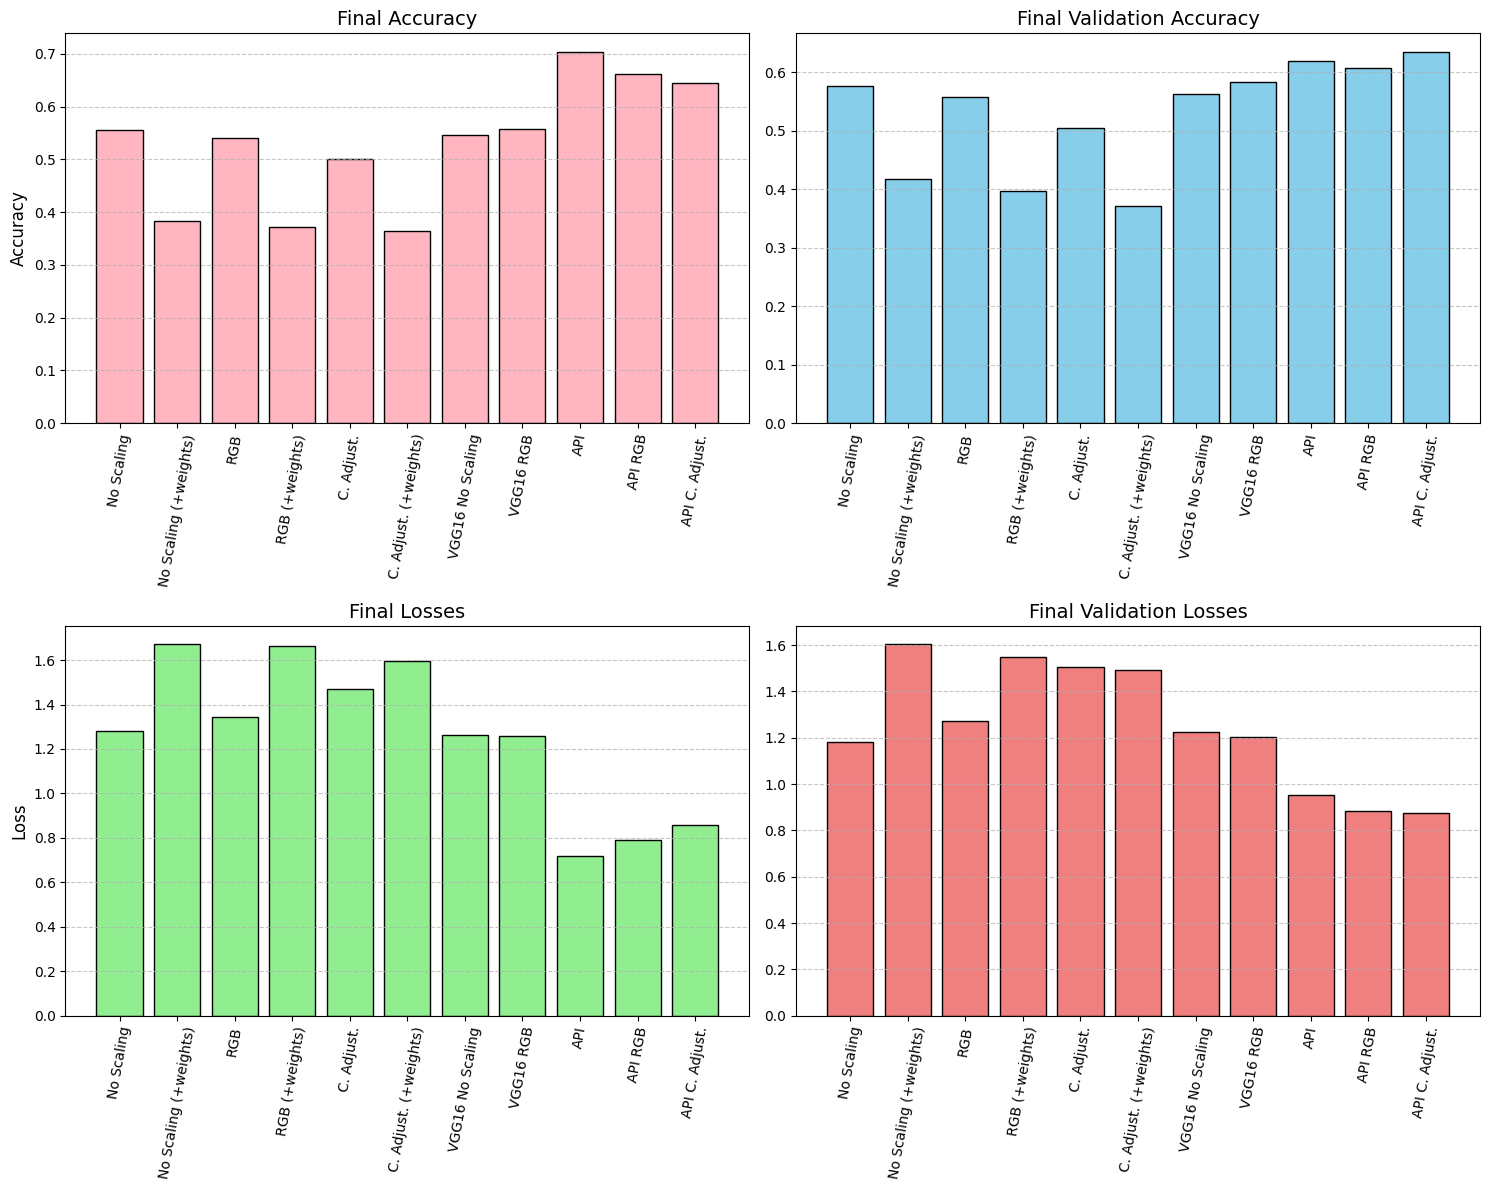

In [ ]:
plot_val_scores(multiclass_histories, multiclass_model_names, False)

##### 4.3.2. Test Scores

In [ ]:
multiclass_models = {model_no_scaling_2: [X_test, w_test], 
                     model_no_scaling_3: [X_test, w_test],
                     model_rgb_2: [X_test_rgb, w_test_rgb],  
                     model_rgb_3: [X_test_rgb, w_test_rgb], 
                     model_ca_2: [X_test_ca, w_test_ca],
                     model_ca_3: [X_test_ca, w_test_ca],
                     vgg16_no_scaling_2: [X_test, w_test], 
                     vgg16_rgb_2: [X_test_rgb, w_test_rgb],
                     f_api_no_scaling: [[X_test, y_test],  w_test],
                     f_api_rgb: [[X_test_rgb, y_test_rgb],  w_test_rgb],
                     f_api_ca: [[X_test_ca, y_test_ca],  w_test_ca]}

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


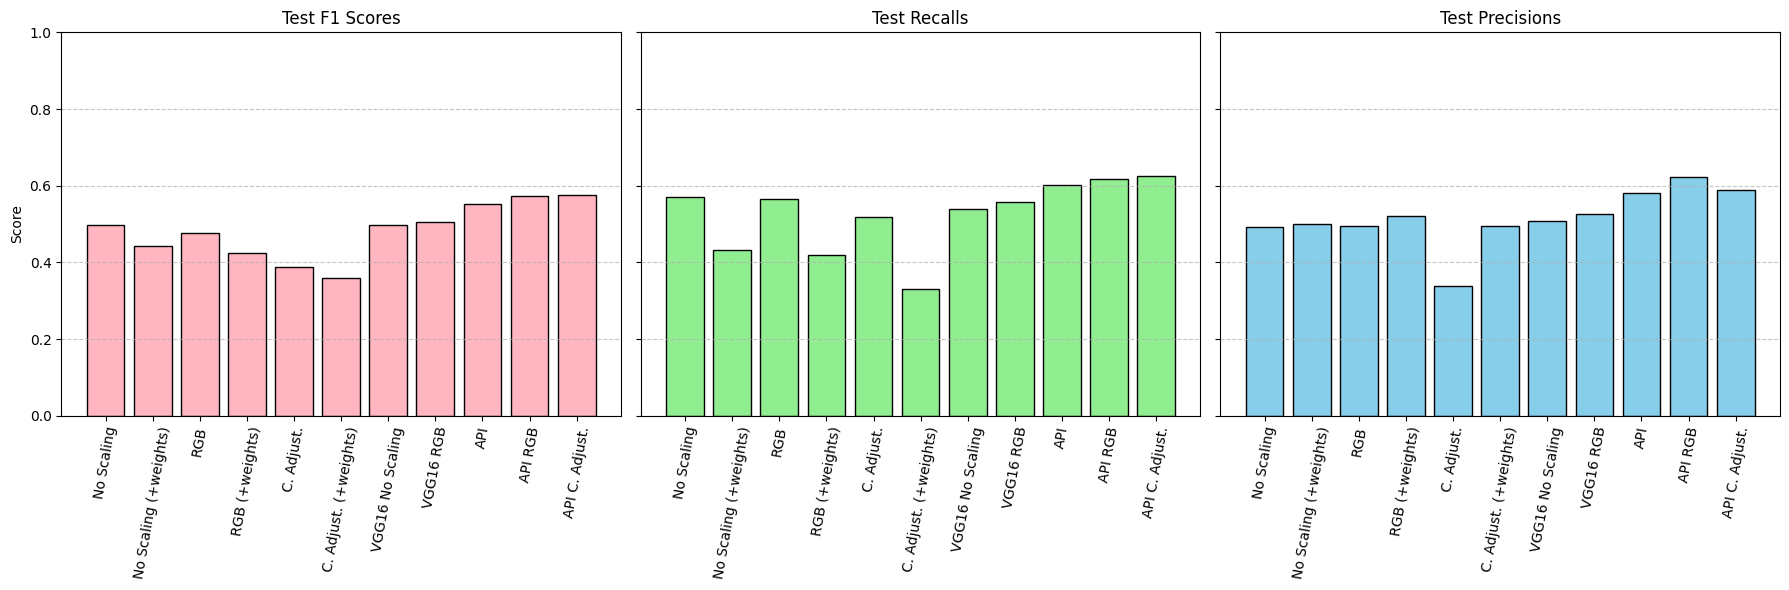

In [ ]:
plot_test_scores(multiclass_models, multiclass_model_names, False)

#### 4.4. Final Model <a class="anchor" id="p44"></a>

In [ ]:
f_api_ca.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 50, 50, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 50, 50,    │        448 │ image_input[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 25, 25,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 25, 25,    │      4,640 │ max_pooling2d_5[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 12, 12,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 12, 12,    │      9,248 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 6, 6, 32)  │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_input        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1152)      │          0 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │         64 │ binary_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1184)      │          0 │ flatten_1[0][0],  │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    303,360 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 8)         │      2,056 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 959,450 (3.66 MB)

 Trainable params: 319,816 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 639,634 (2.44 MB)

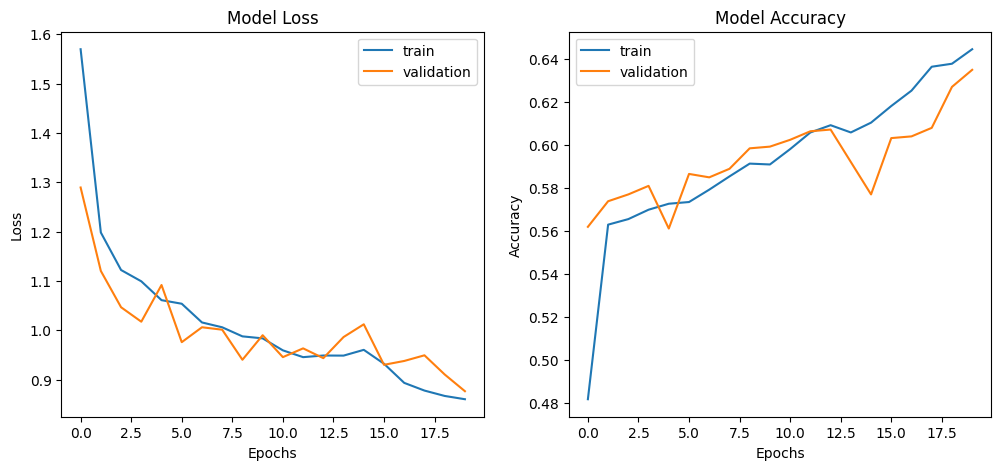

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_history(history27, False)

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


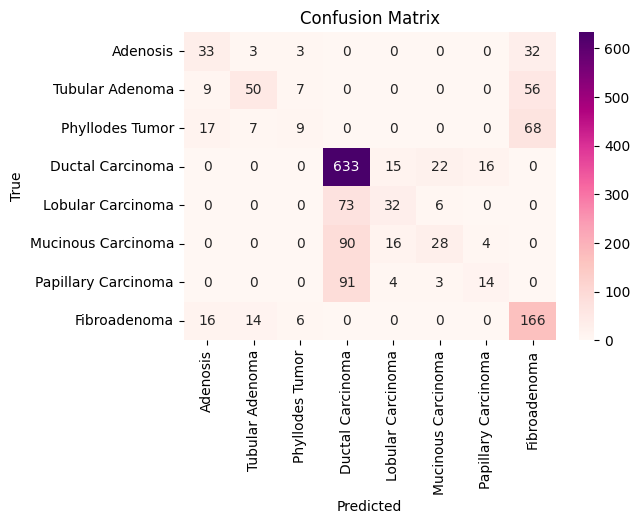

              precision    recall  f1-score   support

           0       0.44      0.46      0.45        71
           1       0.68      0.41      0.51       122
           2       0.36      0.09      0.14       101
           3       0.71      0.92      0.80       686
           4       0.48      0.29      0.36       111
           5       0.47      0.20      0.28       138
           6       0.41      0.12      0.19       112
           7       0.52      0.82      0.63       202

    accuracy                           0.63      1543
   macro avg       0.51      0.42      0.42      1543
weighted avg       0.59      0.63      0.58      1543



In [ ]:
classes = ['Adenosis', 'Tubular Adenoma', 'Phyllodes Tumor', 'Ductal Carcinoma',
           'Lobular Carcinoma', 'Mucinous Carcinoma', 'Papillary Carcinoma', 'Fibroadenoma']

plot_confusion_matrix(f_api_ca, [X_test_ca,y_test_ca], w_test_ca, classes, False)

[Back to TOC](#toc)